In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy as sc

from sciso.plot import *

Set plot style

In [3]:
set_nature_style()

# QC of natural isotope abundance correction and single-cell analysis

## Set paths

In [4]:
# Input
data_dir = Path(r"/media/buglakova/embl_data/data/lipid_isotope/20220322_AB_DKFZHypoxia") 
anndata_dir = data_dir / "anndata"
adata_path = anndata_dir / "hypoxia_adata_concat.h5ad"
adata_am_path =anndata_dir / "hypoxia_adata_am_concat.h5ad"

# Output
plots_path = data_dir / "qc_plots"
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

## Load anndata

In [5]:
adata = sc.read_h5ad(adata_path)
adata_am = sc.read_h5ad(adata_am_path)

## Filtering  

- NaNs in count matrix - in some cases one of the fatty acids was not detected, so we have to drop such cells.
- 'C12H24O2-H' was not detected much resulting in a lot of NaNs, so let's drop it.

In [6]:
print_statistics(adata)

Number of cells per dataset
S2W1 232  cells
S2W2 288  cells
S2W3 280  cells
S2W4 154  cells
S2W5 257  cells
S2W6 269  cells
S2W7 325  cells
S2W8 718  cells
S3W1 200  cells
S3W2 407  cells
S3W3 367  cells
S3W4 296  cells
S3W5 244  cells
S3W6 384  cells
S3W7 386  cells
S3W8 300  cells
Number of cells per condition
Normoxia 1644  cells
Hypoxia 1995  cells
Hypoxia + Normoxia 1468  cells
Number of ions:  100
Number of unique formulas:  100


In [7]:
skip_ions = ["C12H24O2-H"]
adata_filtered = adata[:, ~adata.var.unlabeled_annotation_id.isin(skip_ions)]
adata_am_filtered = adata_am[:, ~adata_am.var.unlabeled_annotation_id.isin(skip_ions)]

In [8]:
rows_without_nan = ~np.isnan(adata_filtered.layers["corr_norm"]).any(axis=1)
adata_filtered = adata_filtered[rows_without_nan, :]

In [9]:
print_statistics(adata_filtered)

Number of cells per dataset
S2W1 232  cells
S2W2 280  cells
S2W3 279  cells
S2W4 149  cells
S2W5 187  cells
S2W6 256  cells
S2W7 281  cells
S2W8 561  cells
S3W1 199  cells
S3W2 407  cells
S3W3 366  cells
S3W4 295  cells
S3W5 244  cells
S3W6 384  cells
S3W7 386  cells
S3W8 300  cells
Number of cells per condition
Normoxia 1529  cells
Hypoxia 1972  cells
Hypoxia + Normoxia 1305  cells
Number of ions:  87
Number of unique formulas:  87


## Compare fatty acid detection over slides and wells

QC to check reproducibility across slides.

In [10]:
adata_am_intra = adata_am_filtered[adata_am_filtered.obs.am_sampling_area > 0, :]

In [11]:
print_statistics(adata_am_intra)

Number of cells per dataset
S2W1 3151  cells
S2W2 4112  cells
S2W3 4243  cells
S2W4 2982  cells
S2W5 4794  cells
S2W6 4235  cells
S2W7 4732  cells
S2W8 10090  cells
S3W1 2341  cells
S3W2 4165  cells
S3W3 5288  cells
S3W4 3171  cells
S3W5 2941  cells
S3W6 4738  cells
S3W7 4218  cells
S3W8 3380  cells
Number of cells per condition
Normoxia 22177  cells
Hypoxia 26781  cells
Hypoxia + Normoxia 19623  cells
Number of ions:  87
Number of unique formulas:  87


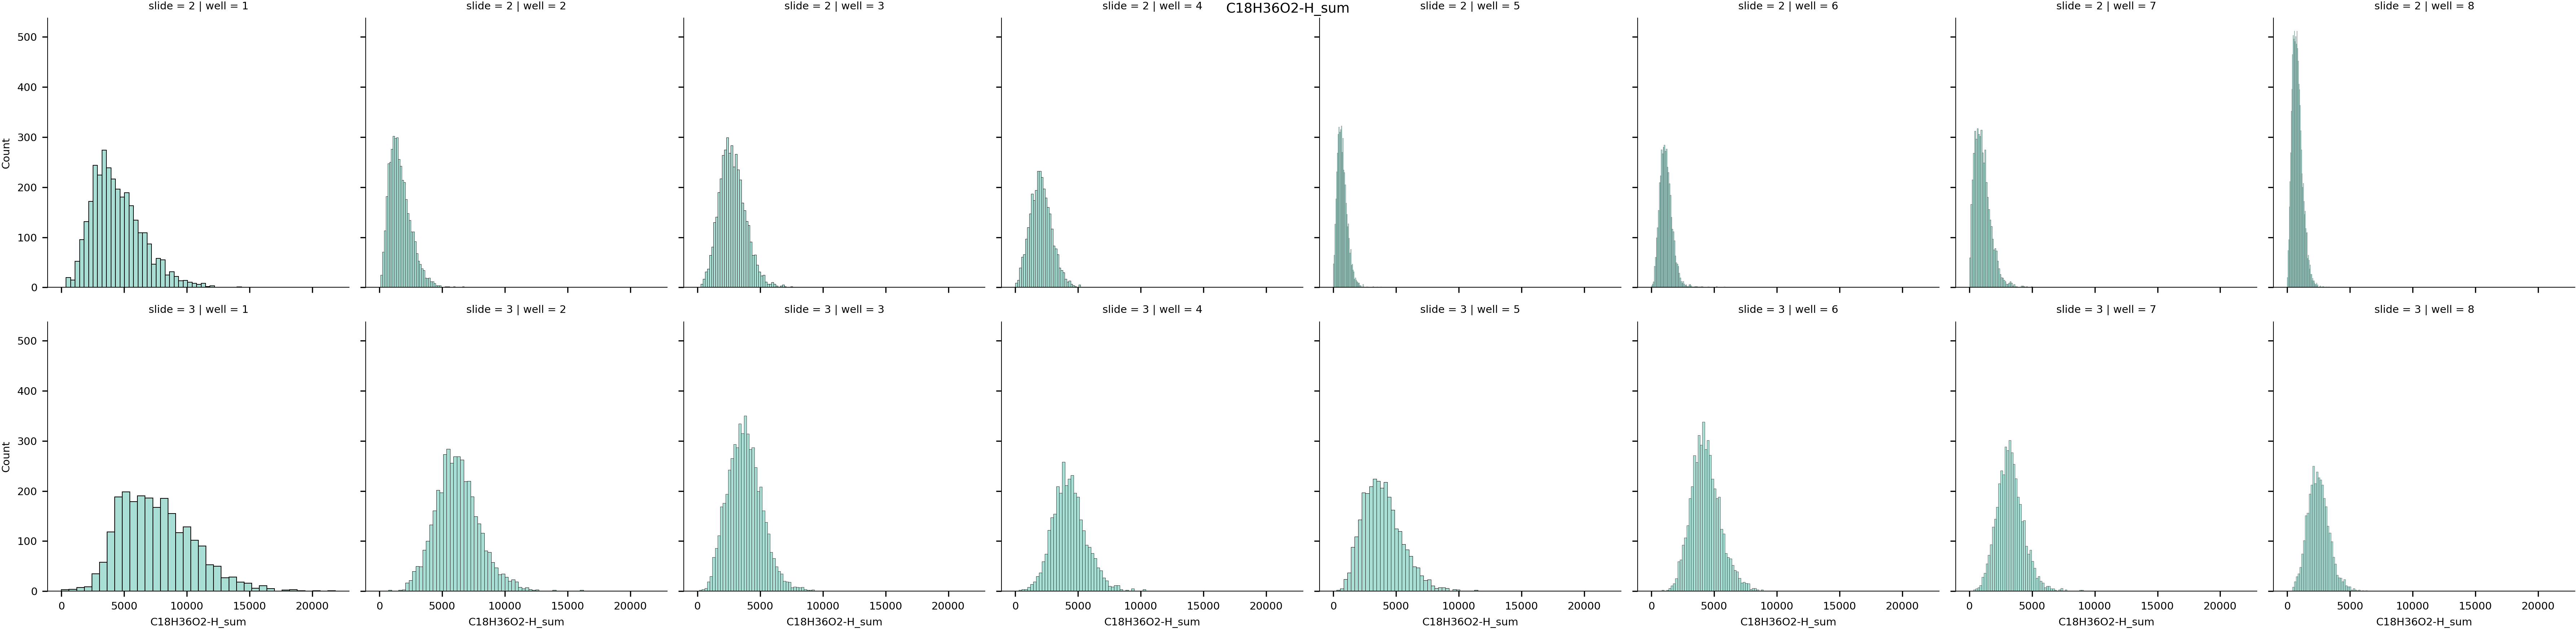

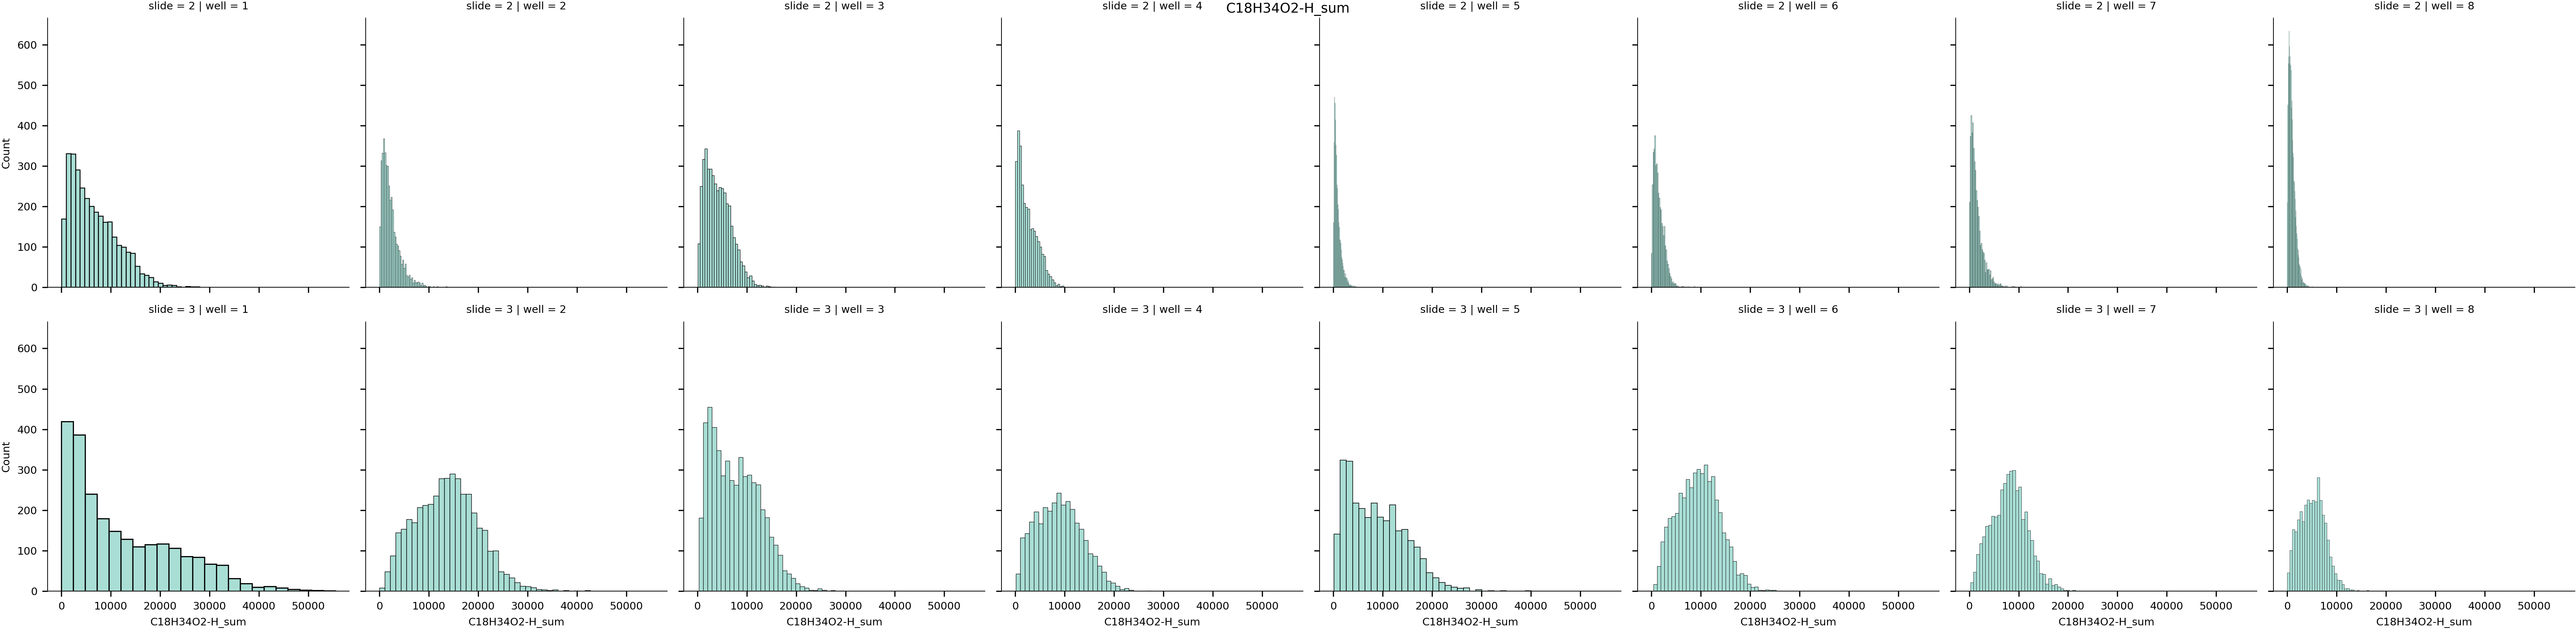

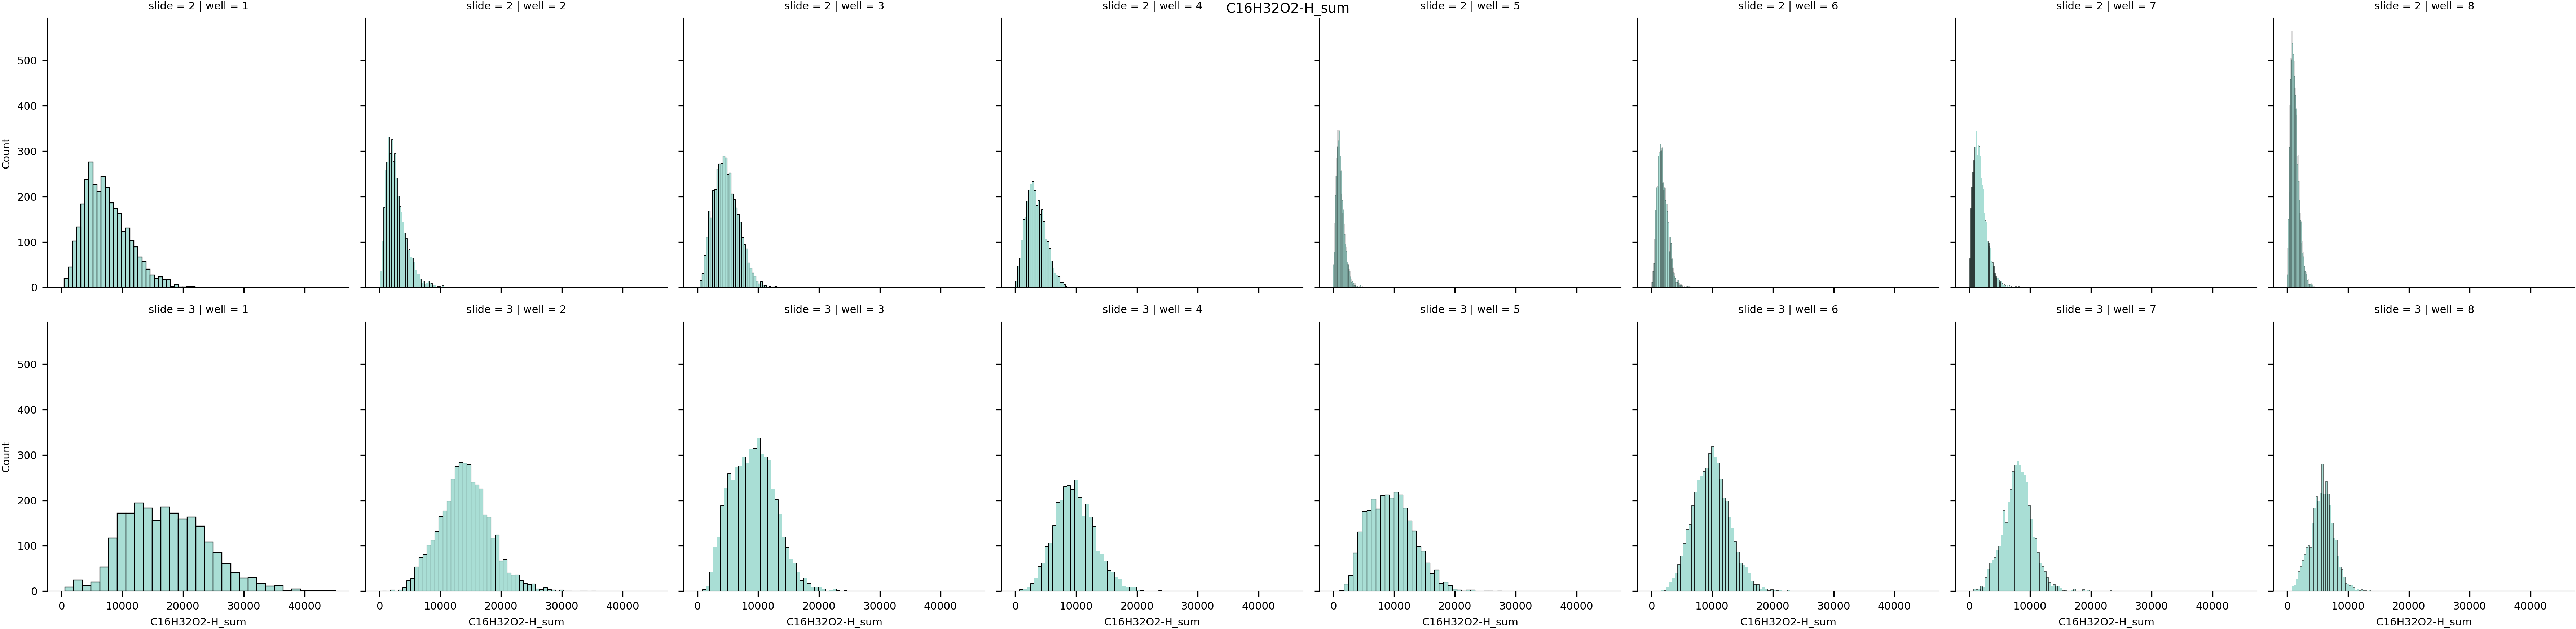

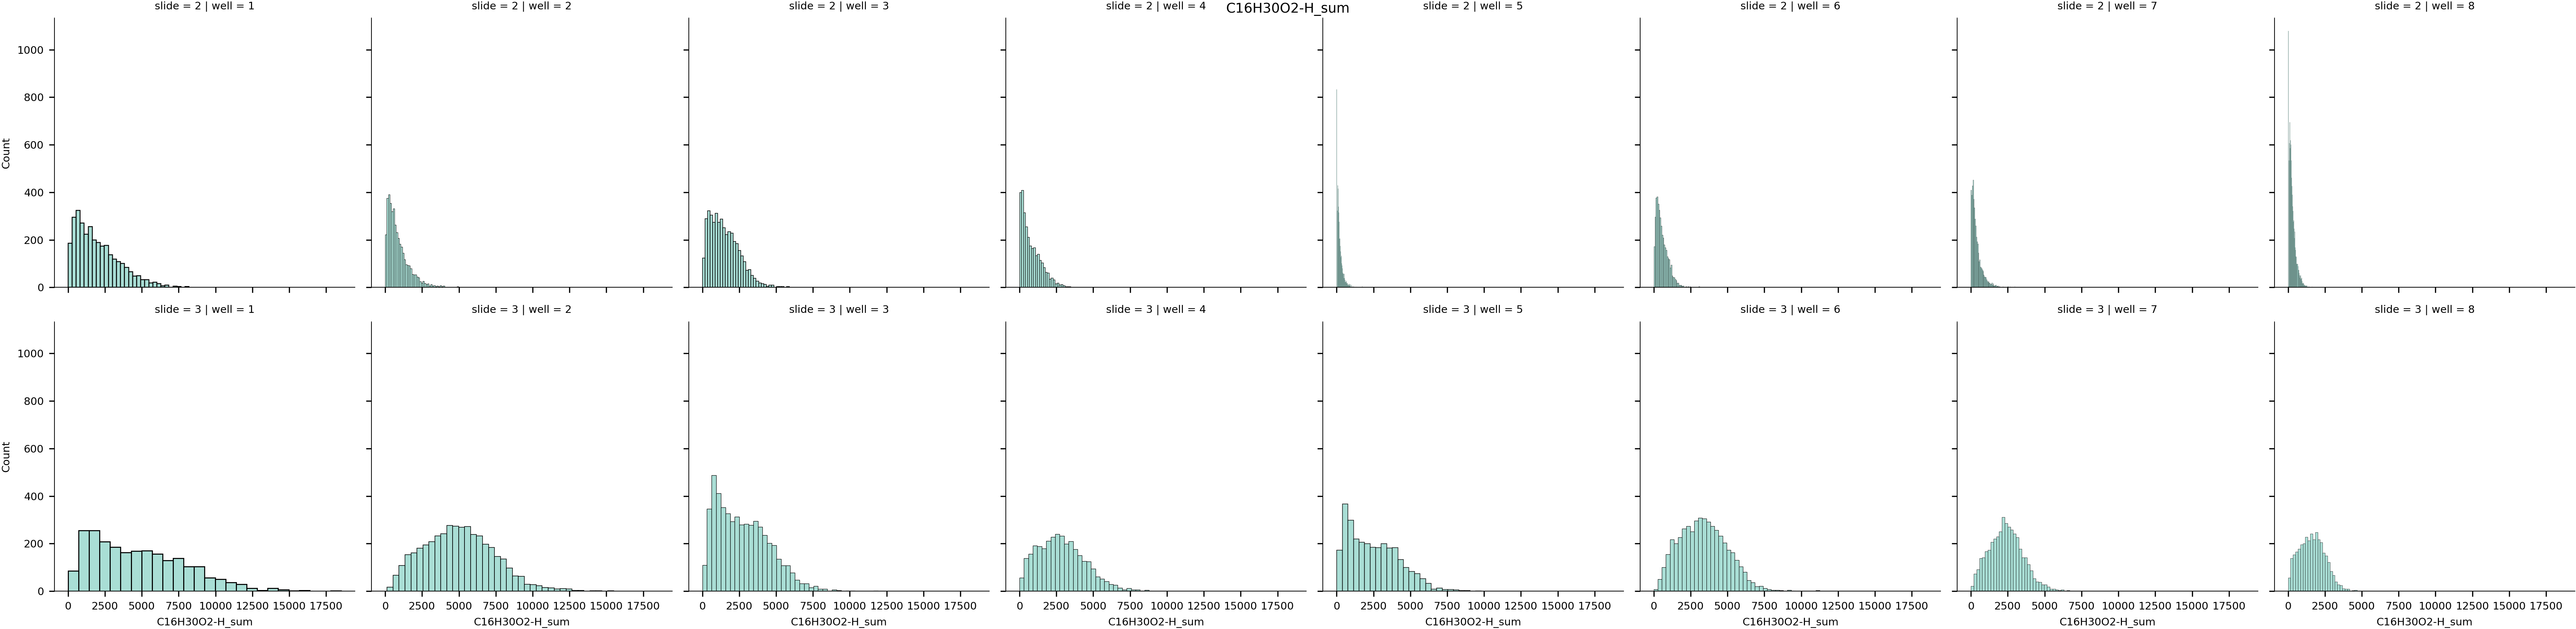

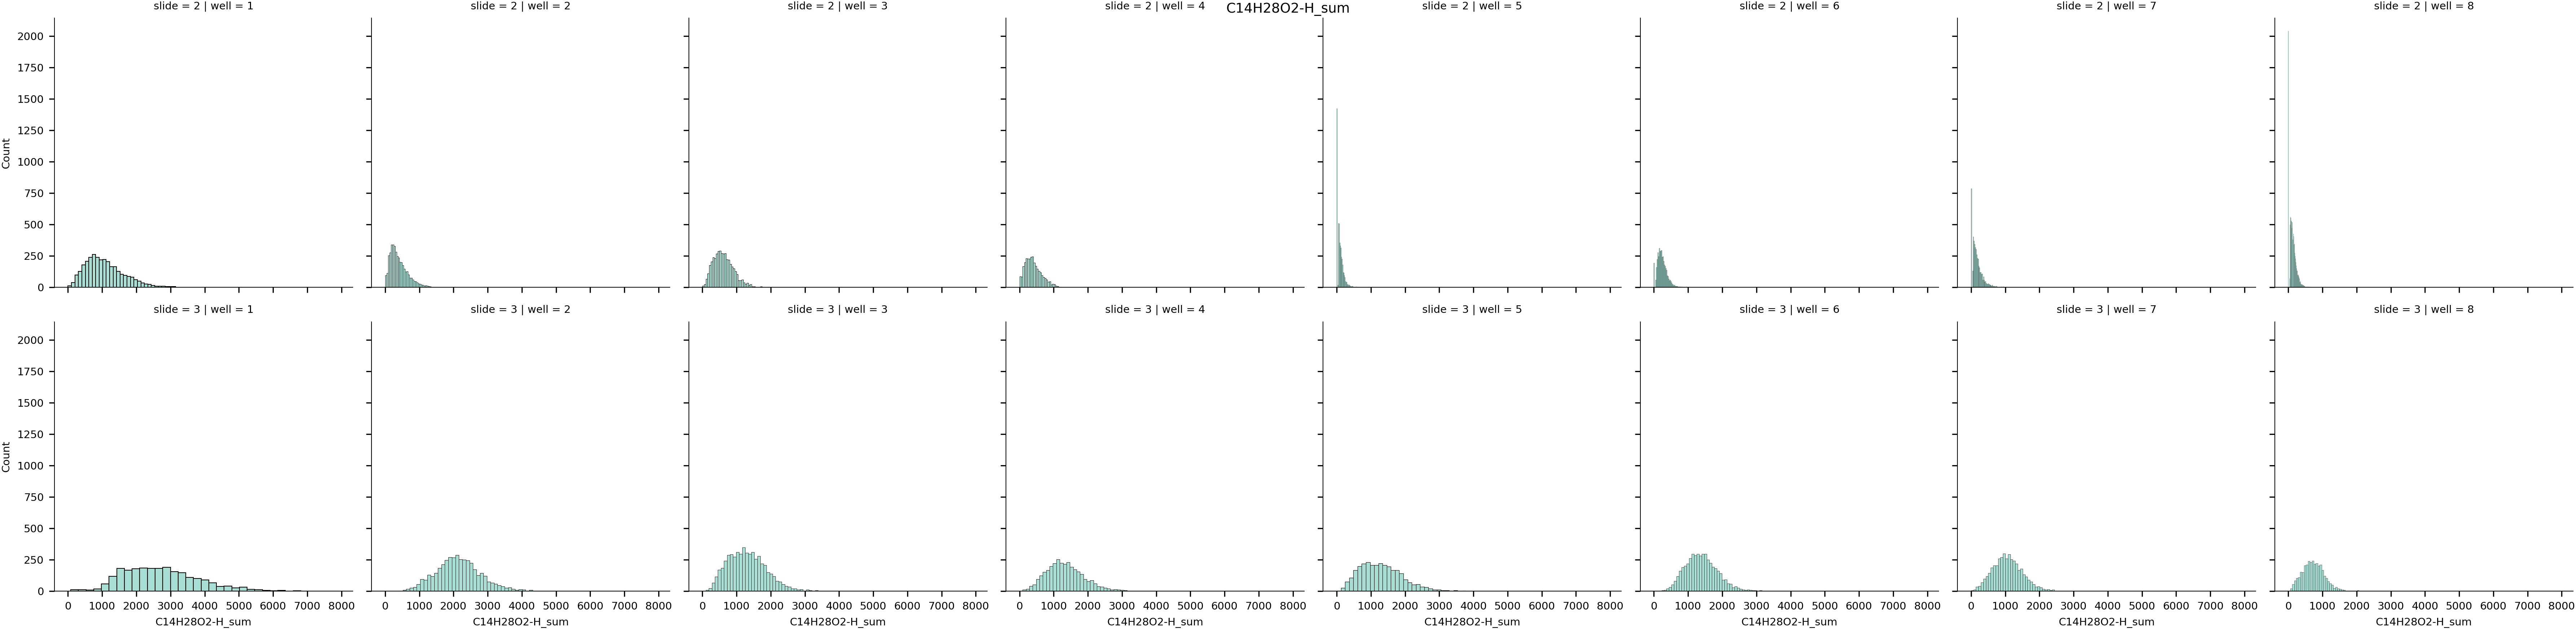

In [12]:
plot_sum_intensities(adata_am_intra, plots_path)

## Filter by cell size

In [13]:
adata

AnnData object with n_obs × n_vars = 5107 × 100
    obs: 'center_x', 'center_y', 'cell_area', 'cell_sampling_area', 'cell_sampling_ratio', 'cell_nearest_am_distance', 'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'local_centroid-0', 'local_centroid-1', 'area', 'filled_area', 'solidity', 'perimeter', 'eccentricity', 'euler_number', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'major_axis_length', 'minor_axis_length', 'weighted_moments_central-0-0-Dapi', 

<ipython-input-14-a67e93b05507>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs["log_cell_area"] = np.log10(adata_filtered.obs.cell_area)


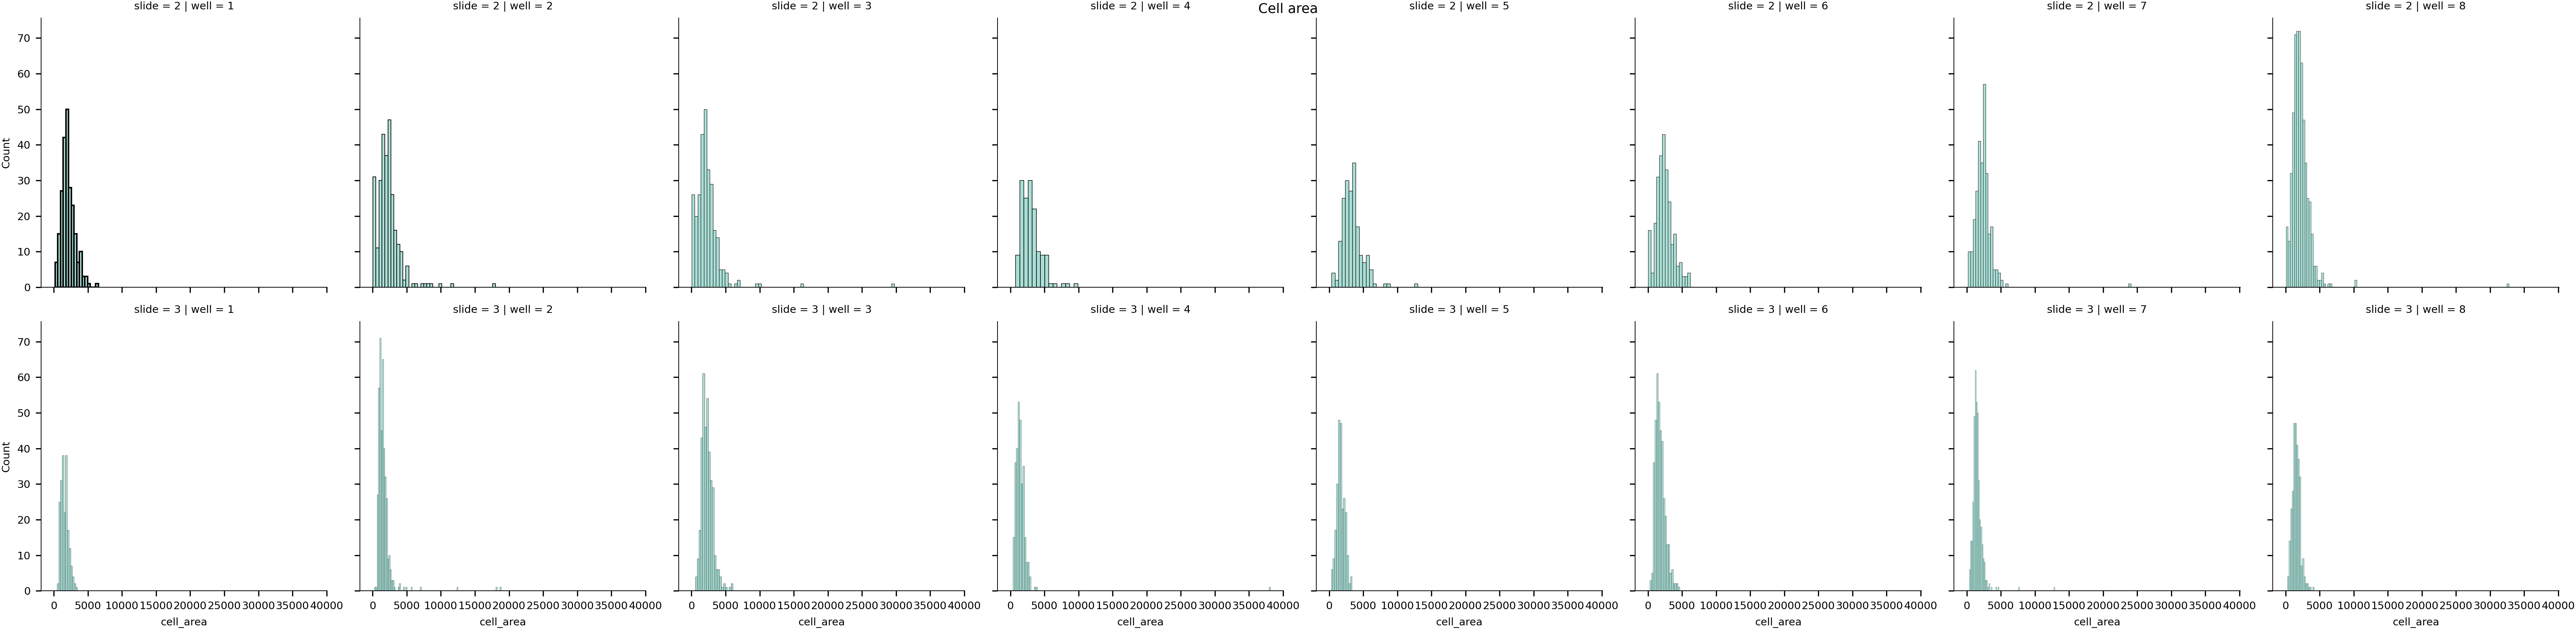

In [14]:
adata_filtered.obs["log_cell_area"] = np.log10(adata_filtered.obs.cell_area)
g = sns.FacetGrid(adata_filtered.obs, col="well",  row="slide")
g.map_dataframe(sns.histplot, x="cell_area")
g.fig.suptitle("Cell area")
plt.savefig(plots_path / f"hist_per_slide_cell_area.png")
plt.show()

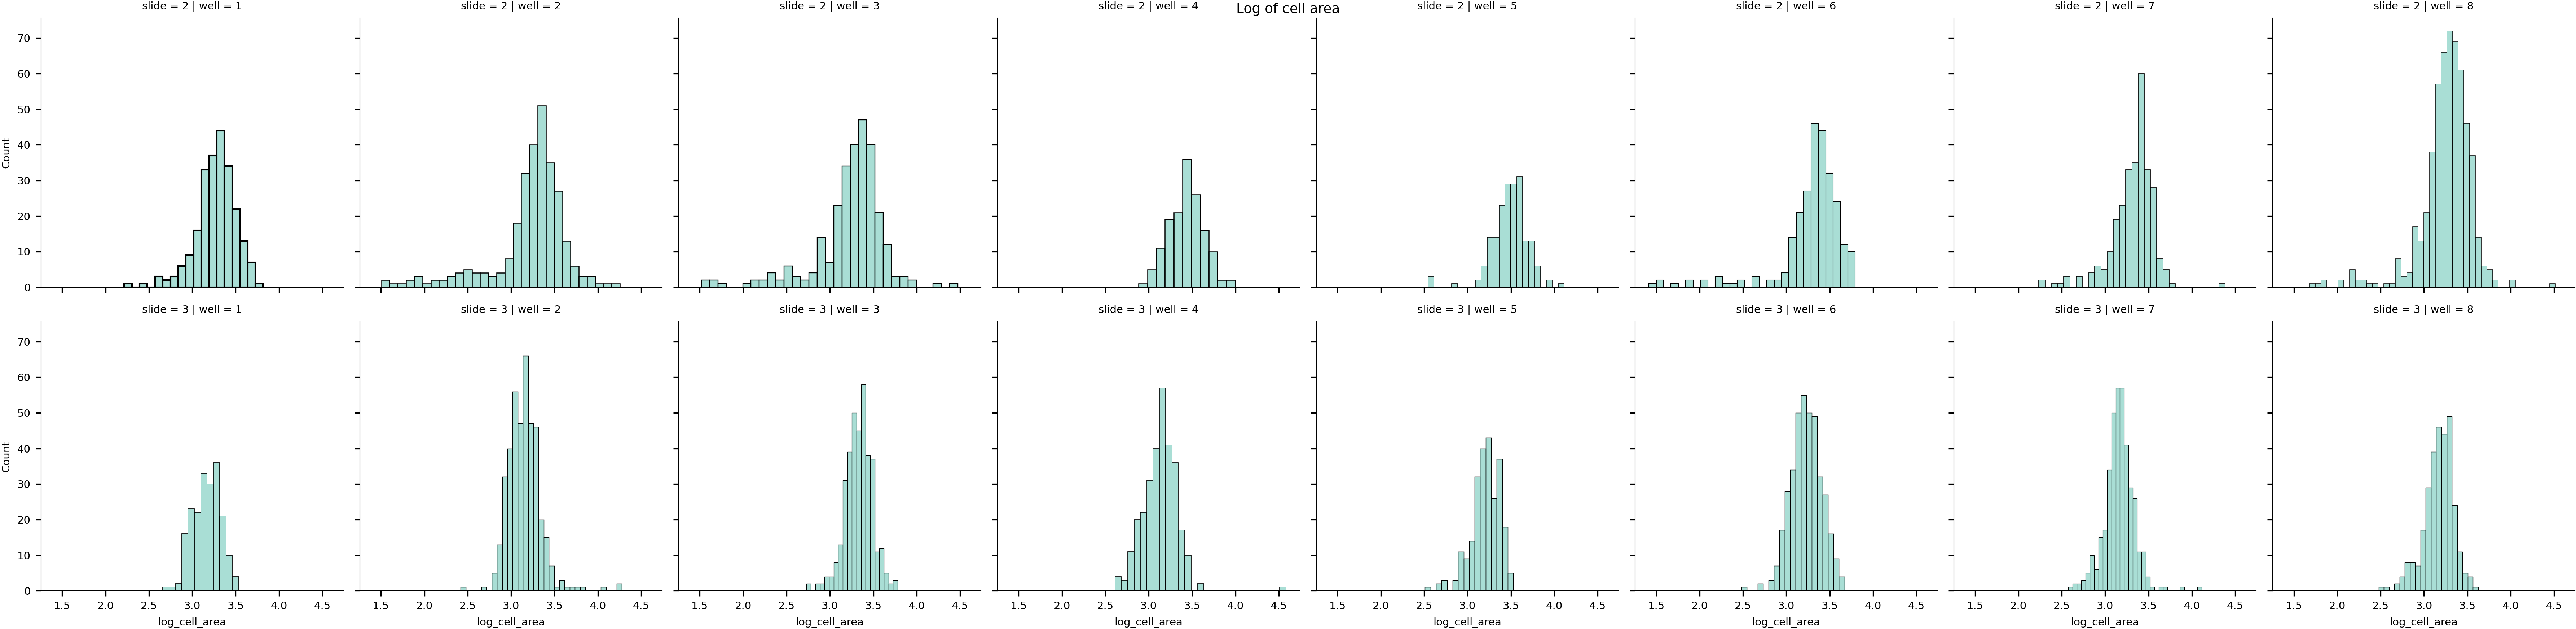

In [15]:
adata_filtered.obs["log_cell_area"] = np.log10(adata_filtered.obs.cell_area)
g = sns.FacetGrid(adata_filtered.obs, col="well",  row="slide")
g.map_dataframe(sns.histplot, x="log_cell_area")
g.fig.suptitle("Log of cell area")
plt.savefig(plots_path / f"hist_per_slide_log_cell_area.png")
plt.show()

In [16]:
cell_area_thrsh = 400

adata_filtered = adata_filtered[adata_filtered.obs.cell_area > cell_area_thrsh, :]

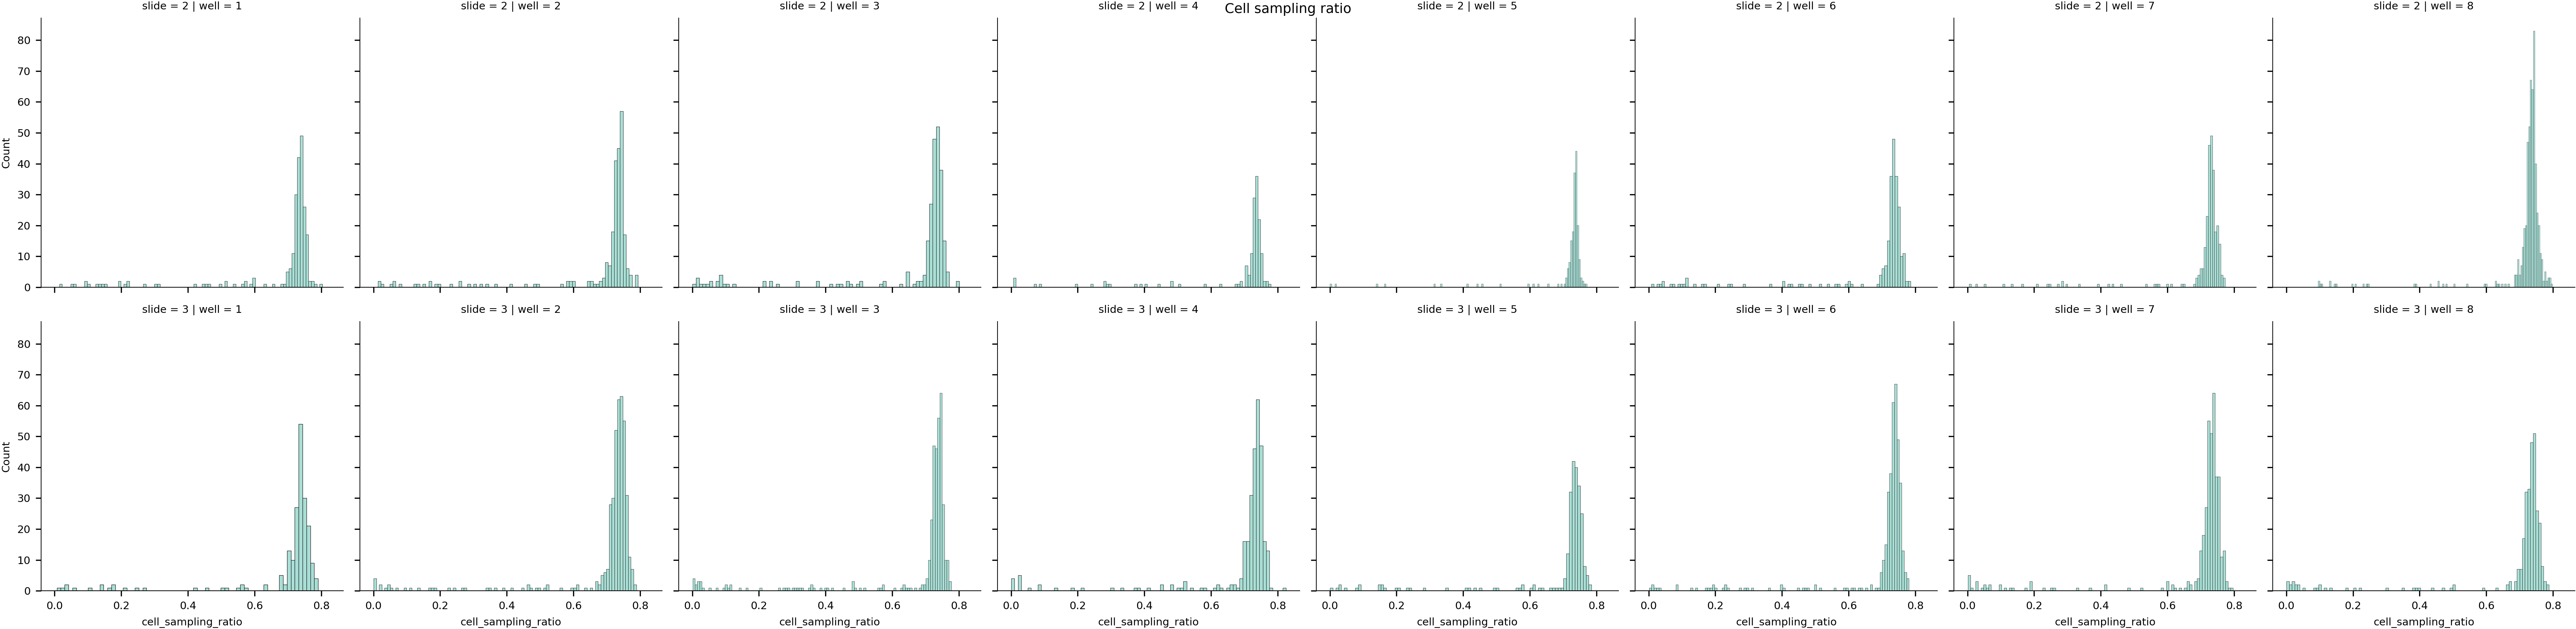

In [17]:
g = sns.FacetGrid(adata_filtered.obs, col="well",  row="slide")
g.map_dataframe(sns.histplot, x="cell_sampling_ratio")
g.fig.suptitle("Cell sampling ratio")
plt.savefig(plots_path / f"hist_per_slide_cell_sampling_ratio.png")
plt.show()

In [18]:
cell_sampling_ration_thrsh = 0.5

adata_filtered = adata_filtered[adata_filtered.obs.cell_sampling_ratio > cell_sampling_ration_thrsh, :]

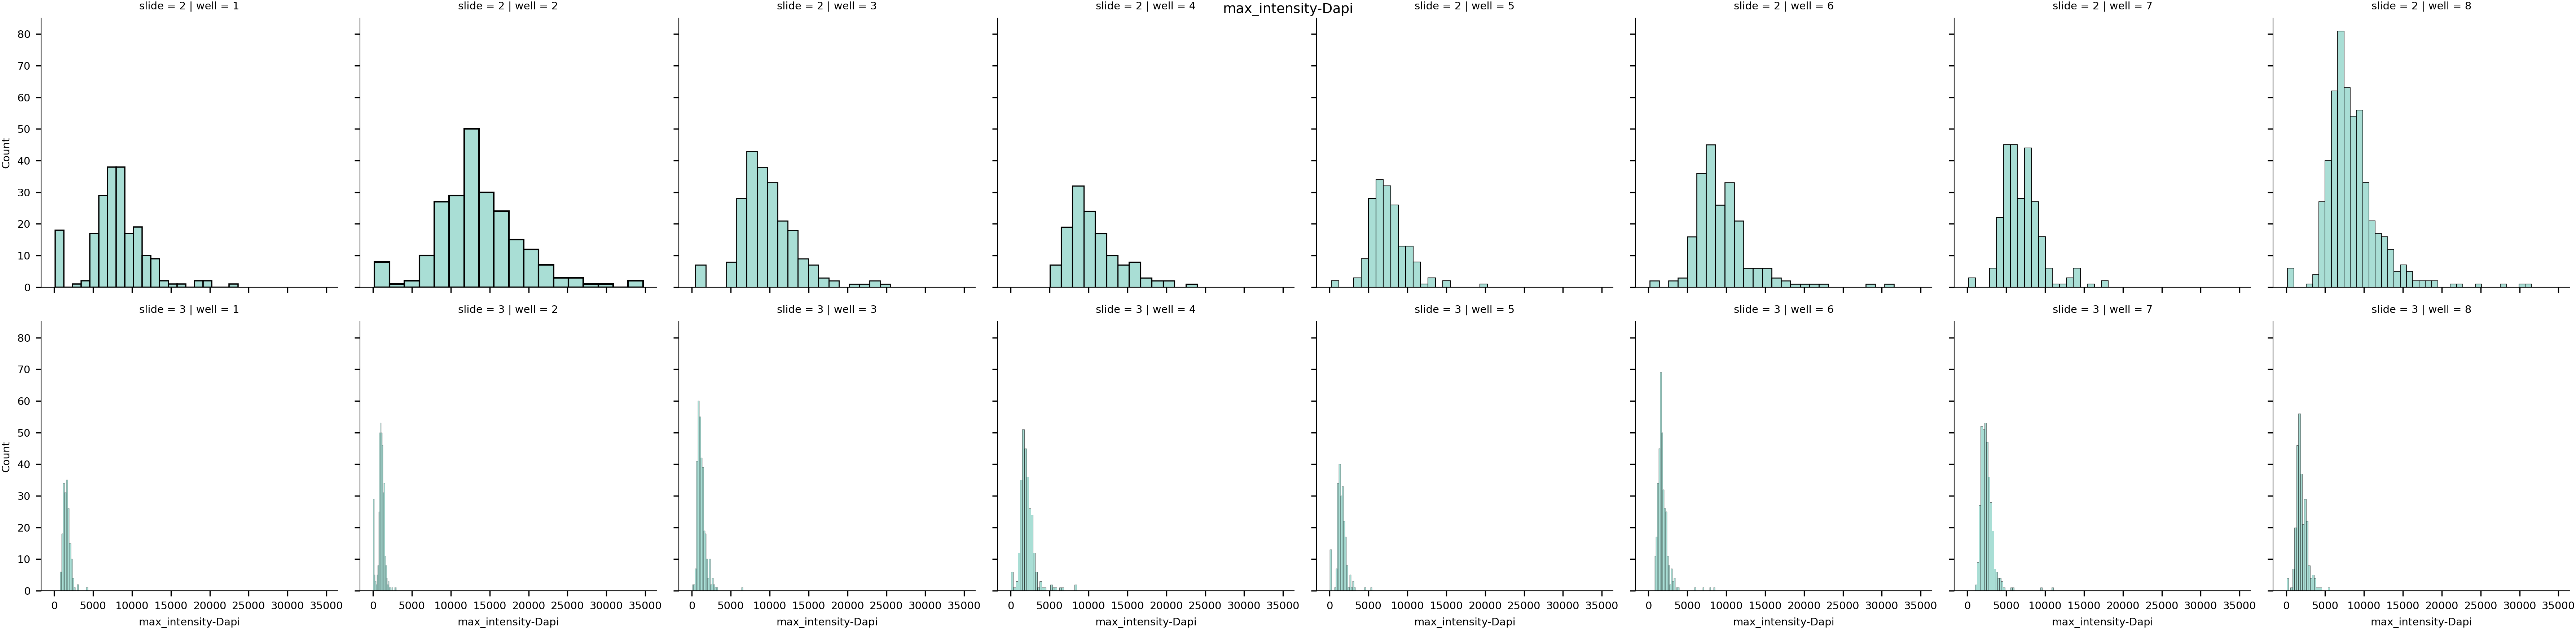

In [19]:
g = sns.FacetGrid(adata_filtered.obs, col="well",  row="slide")
g.map_dataframe(sns.histplot, x="max_intensity-Dapi")
g.fig.suptitle("max_intensity-Dapi")
plt.savefig(plots_path / f"hist_per_slide_max_dapi.png")
plt.show()

In [20]:
print_statistics(adata_filtered)

Number of cells per dataset
S2W1 207  cells
S2W2 225  cells
S2W3 222  cells
S2W4 132  cells
S2W5 175  cells
S2W6 213  cells
S2W7 256  cells
S2W8 524  cells
S3W1 183  cells
S3W2 374  cells
S3W3 320  cells
S3W4 271  cells
S3W5 218  cells
S3W6 350  cells
S3W7 353  cells
S3W8 268  cells
Number of cells per condition
Normoxia 1392  cells
Hypoxia 1704  cells
Hypoxia + Normoxia 1195  cells
Number of ions:  87
Number of unique formulas:  87


In [29]:
adata_filtered.obs[["growthConditions", 'condition', "well"]].pivot_table(columns=["growthConditions", 'condition'], aggfunc="count")

growthConditions Labeled                             Unlabeled  \
condition        Hypoxia Hypoxia + Normoxia Normoxia   Hypoxia   
well                1105               1195     1002       599   

growthConditions                              
condition        Hypoxia + Normoxia Normoxia  
well                              0      390

In [21]:
output_file = anndata_dir / "hypoxia_adata_concat_filtered.h5ad"
adata_filtered.write(output_file.with_suffix(".h5ad"))

## Plot all AMs for a given cell and given FA

Maybe add later

In [22]:
print("All ions:")
print(adata_filtered.var.unlabeled_annotation_id.unique())

All ions:
['C18H36O2-H', 'C18H34O2-H', 'C16H32O2-H', 'C16H30O2-H', 'C14H28O2-H']
Categories (5, object): ['C14H28O2-H', 'C16H30O2-H', 'C16H32O2-H', 'C18H34O2-H', 'C18H36O2-H']


In [23]:
ion = 'C18H36O2-H'
batch = "S3W4"
cell = 1301

In [24]:
sc.read_h5ad("/media/buglakova/embl_data/data/lipid_isotope/20220322_AB_DKFZHypoxia/anndata/hypoxia_adata_concat_filtered.h5ad")

AnnData object with n_obs × n_vars = 4291 × 87
    obs: 'center_x', 'center_y', 'cell_area', 'cell_sampling_area', 'cell_sampling_ratio', 'cell_nearest_am_distance', 'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'local_centroid-0', 'local_centroid-1', 'area', 'filled_area', 'solidity', 'perimeter', 'eccentricity', 'euler_number', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'major_axis_length', 'minor_axis_length', 'weighted_moments_central-0-0-Dapi', '